# ECE 447 Project

## Authors
Kyle Bricker - 1578023  
Max Eberle - 1576215  
Dhruv Pranlal - 1628666

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.cluster import KMeans

from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import warnings
warnings.simplefilter("ignore")

In [2]:
df=pd.read_csv("zoo.csv")
target_names = list(set(df["type"])) # gets array of zoo animal types
# target_names = [item.strip('\'').replace('b\'','') for item in target_names]
# print(target_names)

# df.type.replace({'b\'reptile\'':'reptile','b\'bird\'':'bird','b\'amphibian\'':'amphibian','b\'insect\'':'insect','b\'fish\'':'fish','b\'mammal\'':'mammal','b\'invertebrate\'':'invertabrate'}, inplace=True)
df.type.replace({'b\'reptile\'':0,'b\'bird\'':1,'b\'amphibian\'':2,'b\'insect\'':3,'b\'fish\'':4,'b\'mammal\'':5,'b\'invertebrate\'':6}, inplace=True)
df.hair.replace({'b\'true\'':1, 'b\'false\'':0}, inplace=True)
df.feathers.replace({'b\'true\'':1, 'b\'false\'':0}, inplace=True)
df.eggs.replace({'b\'true\'':1, 'b\'false\'':0}, inplace=True)
df.milk.replace({'b\'true\'':1, 'b\'false\'':0}, inplace=True)
df.airborne.replace({'b\'true\'':1, 'b\'false\'':0}, inplace=True)
df.aquatic.replace({'b\'true\'':1, 'b\'false\'':0}, inplace=True)
df.predator.replace({'b\'true\'':1, 'b\'false\'':0}, inplace=True)
df.toothed.replace({'b\'true\'':1, 'b\'false\'':0}, inplace=True)
df.backbone.replace({'b\'true\'':1, 'b\'false\'':0}, inplace=True)
df.breathes.replace({'b\'true\'':1, 'b\'false\'':0}, inplace=True)
df.venomous.replace({'b\'true\'':1, 'b\'false\'':0}, inplace=True)
df.fins.replace({'b\'true\'':1, 'b\'false\'':0}, inplace=True)
df['tail'].replace({'b\'true\'':1, 'b\'false\'':0}, inplace=True)
df.domestic.replace({'b\'true\'':1, 'b\'false\'':0}, inplace=True)
df.catsize.replace({'b\'true\'':1, 'b\'false\'':0}, inplace=True)

X=df.drop(columns=['type', 'animal'])
y=df['type']
target_names = ['Reptile','Bird','Amphibian','Insect','Fish','Mammal','Invertebrate']
target_labels = [0,1,2,3,4,5,6]
print(target_names)
feature_names = list(X.columns)
print(feature_names)

display(X)
display(y)

['Reptile', 'Bird', 'Amphibian', 'Insect', 'Fish', 'Mammal', 'Invertebrate']
['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail', 'domestic', 'catsize']


,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,1,0,0,1,0,0,1,1,1,1,0,0,4.0,0,0,1
1,1,0,0,1,0,0,0,1,1,1,0,0,4.0,1,0,1
2,0,0,1,0,0,1,1,1,1,0,0,1,0.0,1,0,0
3,1,0,0,1,0,0,1,1,1,1,0,0,4.0,0,0,1
4,1,0,0,1,0,0,1,1,1,1,0,0,4.0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1,0,0,1,0,0,0,1,1,1,0,0,2.0,1,0,1
97,1,0,1,0,1,0,0,0,0,1,1,0,6.0,0,0,0
98,1,0,0,1,0,0,1,1,1,1,0,0,4.0,1,0,1
99,0,0,1,0,0,0,0,0,0,1,0,0,0.0,0,0,0


0      5
1      5
2      4
3      5
4      5
      ..
96     5
97     3
98     5
99     6
100    1
Name: type, Length: 101, dtype: int64

In [3]:
X.describe()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.425743,0.198020,0.584158,0.405941,0.237624,0.356436,0.554455,0.603960,0.821782,0.792079,0.079208,0.168317,2.841584,0.742574,0.128713,0.435644
std,0.496921,0.400495,0.495325,0.493522,0.427750,0.481335,0.499505,0.491512,0.384605,0.407844,0.271410,0.376013,2.033385,0.439397,0.336552,0.498314
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000


In [4]:
print(target_names)
y.describe()

['Reptile', 'Bird', 'Amphibian', 'Insect', 'Fish', 'Mammal', 'Invertebrate']


count    101.000000
mean       3.653465
std        1.878487
min        0.000000
25%        2.000000
50%        5.000000
75%        5.000000
max        6.000000
Name: type, dtype: float64

In [5]:
# get testing and training values for the models
X_train, X_test, Y_train, Y_test = train_test_split( X.values , y , test_size = 0.3, random_state = 3)

# Decision Tree Model

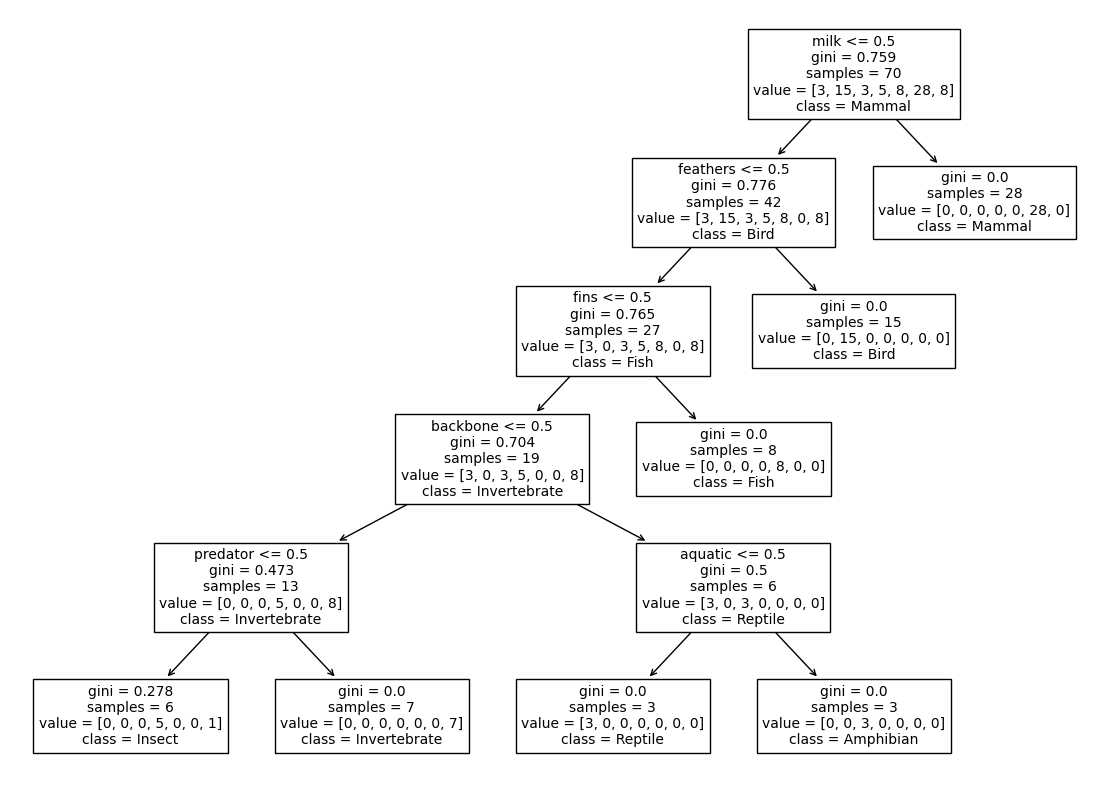

In [6]:
clf = DecisionTreeClassifier(max_depth=5)
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

plt.figure(figsize=(14,10))
tree.plot_tree(clf, feature_names=feature_names, class_names=target_names, fontsize=10)
plt.show()
#

              precision    recall  f1-score   support

     Reptile       1.00      0.50      0.67         2
        Bird       1.00      1.00      1.00         5
   Amphibian       0.50      1.00      0.67         1
      Insect       0.67      0.67      0.67         3
        Fish       1.00      1.00      1.00         5
      Mammal       1.00      1.00      1.00        13
Invertebrate       0.50      0.50      0.50         2

    accuracy                           0.90        31
   macro avg       0.81      0.81      0.79        31
weighted avg       0.92      0.90      0.90        31



<AxesSubplot:>

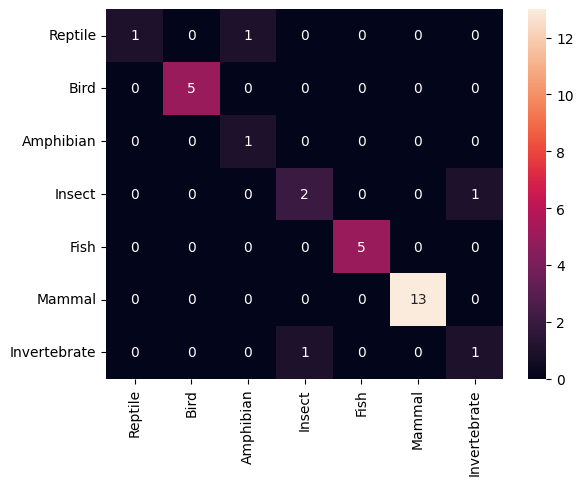

In [7]:
print(classification_report(Y_test, Y_pred, target_names=target_names, labels=target_labels))
cm = confusion_matrix(Y_test, Y_pred, labels=target_labels, )

# disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
# disp.plot()
# plt.xticks(target_labels, target_names, rotation='vertical')
# plt.show()
sns.heatmap(cm, yticklabels=target_names, xticklabels=target_names, annot=True)

# Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split( X.values , y , test_size = 0.3, random_state = 3)

In [10]:
model_lr = LogisticRegression(max_iter = 101)
model_lr.fit(X_train, Y_train)

LogisticRegression(max_iter=101)

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         3
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00         2

    accuracy                           0.97        31
   macro avg       0.98      0.93      0.94        31
weighted avg       0.97      0.97      0.96        31



<AxesSubplot:>

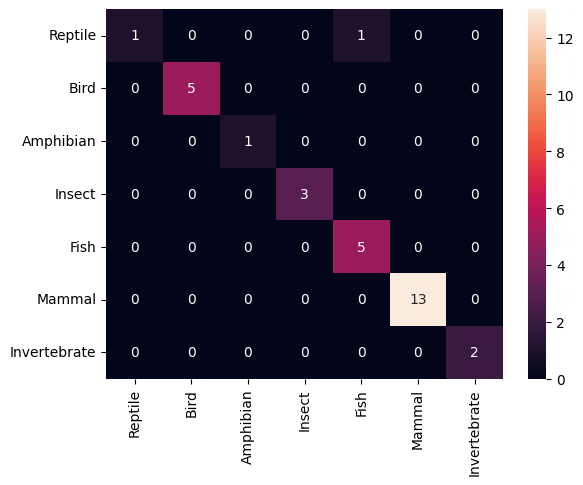

In [11]:
Y_pred_lr = model_lr.predict(X_test)
cr_lr = classification_report(Y_test, Y_pred_lr)
print(cr_lr)
cm = confusion_matrix(Y_test, Y_pred_lr, labels=target_labels,)
sns.heatmap(cm, yticklabels=target_names, xticklabels=target_names, annot=True)

# Clustering

In [12]:
df

,animal,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,b'aardvark',1,0,0,1,0,0,1,1,1,1,0,0,4.0,0,0,1,5
1,b'antelope',1,0,0,1,0,0,0,1,1,1,0,0,4.0,1,0,1,5
2,b'bass',0,0,1,0,0,1,1,1,1,0,0,1,0.0,1,0,0,4
3,b'bear',1,0,0,1,0,0,1,1,1,1,0,0,4.0,0,0,1,5
4,b'boar',1,0,0,1,0,0,1,1,1,1,0,0,4.0,1,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,b'wallaby',1,0,0,1,0,0,0,1,1,1,0,0,2.0,1,0,1,5
97,b'wasp',1,0,1,0,1,0,0,0,0,1,1,0,6.0,0,0,0,3
98,b'wolf',1,0,0,1,0,0,1,1,1,1,0,0,4.0,1,0,1,5
99,b'worm',0,0,1,0,0,0,0,0,0,1,0,0,0.0,0,0,0,6


In [13]:
df_cleaned = df.drop(["animal", "type"], axis=1)

In [14]:
kmeans = KMeans(
    init="k-means++",
    n_clusters=7,
    n_init=12,
    max_iter=5000,
    random_state=35
)
kmeans.fit(df_cleaned);

In [15]:
labels = kmeans.fit_predict(df_cleaned)
labels

array([3, 3, 5, 3, 3, 3, 3, 5, 5, 3, 3, 4, 5, 1, 6, 0, 4, 3, 5, 5, 4, 4,
       3, 4, 0, 6, 6, 2, 3, 2, 0, 3, 2, 4, 5, 3, 3, 4, 5, 0, 0, 4, 0, 4,
       3, 3, 0, 3, 3, 3, 3, 0, 6, 0, 3, 3, 4, 4, 4, 4, 5, 5, 1, 3, 3, 3,
       5, 3, 3, 3, 3, 4, 0, 5, 5, 2, 5, 1, 4, 4, 1, 1, 5, 4, 2, 6, 5, 4,
       0, 6, 6, 6, 5, 2, 3, 4, 2, 0, 3, 1, 4])

In [16]:
clusters = [[], [], [], [], [], [], []] # array of 7 arrays for our 7 clusters
names = df["animal"]

for idx in range(len(labels)):
    clusters[labels[idx]].append((names[idx], target_names[y[idx]]))

for ct in range(7):
    print(f'\nCluster {ct}:')
    print(clusters[ct])
    types = [x[1] for x in clusters[ct]]
    for name in target_names:
        if types.count(name) > 0:
            print(f"{name}: {types.count(name)}")


Cluster 0:
[("b'crayfish'", 'Invertebrate'), ("b'flea'", 'Insect'), ("b'gnat'", 'Insect'), ("b'honeybee'", 'Insect'), ("b'housefly'", 'Insect'), ("b'ladybird'", 'Insect'), ("b'lobster'", 'Invertebrate'), ("b'moth'", 'Insect'), ("b'octopus'", 'Invertebrate'), ("b'scorpion'", 'Invertebrate'), ("b'termite'", 'Insect'), ("b'wasp'", 'Insect')]
Insect: 8
Invertebrate: 4

Cluster 1:
[("b'clam'", 'Invertebrate'), ("b'pitviper'", 'Reptile'), ("b'seawasp'", 'Invertebrate'), ("b'slowworm'", 'Reptile'), ("b'slug'", 'Invertebrate'), ("b'worm'", 'Invertebrate')]
Reptile: 2
Invertebrate: 4

Cluster 2:
[("b'fruitbat'", 'Mammal'), ("b'girl'", 'Mammal'), ("b'gorilla'", 'Mammal'), ("b'sealion'", 'Mammal'), ("b'squirrel'", 'Mammal'), ("b'vampire'", 'Mammal'), ("b'wallaby'", 'Mammal')]
Mammal: 7

Cluster 3:
[("b'aardvark'", 'Mammal'), ("b'antelope'", 'Mammal'), ("b'bear'", 'Mammal'), ("b'boar'", 'Mammal'), ("b'buffalo'", 'Mammal'), ("b'calf'", 'Mammal'), ("b'cavy'", 'Mammal'), ("b'cheetah'", 'Mammal'), ("

# investigate how the target feature is distributed among clusters (todo)